In [471]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
tf.random.set_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [472]:
df = pd.read_csv("../datasets/perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [473]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

print("Train set:", X_train.shape, y_train.shape)

Train set: (20, 2) (20,)


In [474]:
# scaling for better convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [475]:
print("Training labels:")
counts = Counter(y_train)
for key, value in counts.items():
    print(f"{key}: {value}")

Training labels:
0: 10
1: 10


### Visualize the Dataset

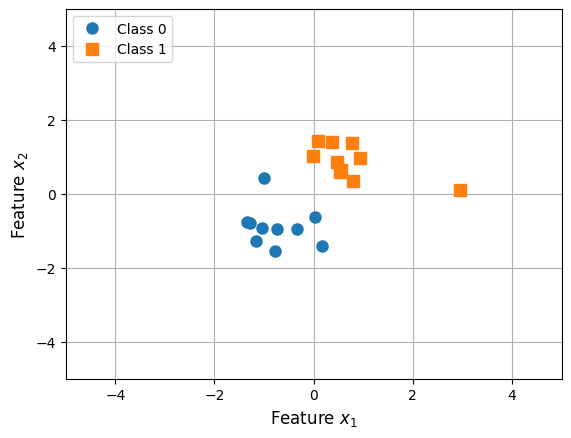

In [476]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train, markersize=8)

### Define the DataLoader

In [477]:
# Reshape labels
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
y_train_reshape = y_train.reshape(-1, 1)

# TensorFlow dataset for mini-batching
batch_size = 10
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_reshape))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

### Design the Model

In [478]:
# initialize weights and bias
n_features = X_train.shape[1]
W = tf.Variable(tf.zeros(shape=(n_features, 1), dtype=tf.float32))
b = tf.Variable(tf.zeros(shape=(1,), dtype=tf.float32))

# forward pass
def logistic_regression(X):
    logits = tf.matmul(X, W) + b
    return tf.sigmoid(logits)

# loss funtion
def binary_cross_entropy(y_true, y_pred):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred + 1e-7) +
                           (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))

### Train the model

In [479]:
num_epochs = 20
learning_rate = 0.05
history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_dataset:
        # forward pass
        with tf.GradientTape() as tape:
            y_pred = logistic_regression(X_batch)
            loss = binary_cross_entropy(y_batch, y_pred)
        
        # backward pass
        gradients = tape.gradient(loss, [W, b])
        W.assign_sub(learning_rate * gradients[0])
        b.assign_sub(learning_rate * gradients[1])
        
        epoch_loss += abs(loss.numpy())
    history.append(epoch_loss)
    print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
          f' | train_loss: {epoch_loss:.2f}')

Epoch: 001/020 | train_loss: 1.37
Epoch: 002/020 | train_loss: 1.31
Epoch: 003/020 | train_loss: 1.25
Epoch: 004/020 | train_loss: 1.19
Epoch: 005/020 | train_loss: 1.14
Epoch: 006/020 | train_loss: 1.10
Epoch: 007/020 | train_loss: 1.05
Epoch: 008/020 | train_loss: 1.01
Epoch: 009/020 | train_loss: 0.97
Epoch: 010/020 | train_loss: 0.94
Epoch: 011/020 | train_loss: 0.90
Epoch: 012/020 | train_loss: 0.87
Epoch: 013/020 | train_loss: 0.84
Epoch: 014/020 | train_loss: 0.82
Epoch: 015/020 | train_loss: 0.79
Epoch: 016/020 | train_loss: 0.77
Epoch: 017/020 | train_loss: 0.75
Epoch: 018/020 | train_loss: 0.72
Epoch: 019/020 | train_loss: 0.70
Epoch: 020/020 | train_loss: 0.69


In [480]:
bias = b[0].numpy()
weights = W.numpy().flatten()
print("Bias:", bias)
print("Weights:", weights)

Bias: -0.00010501128
Weights: [0.5304932  0.64292103]


### Evaluate the Model

In [ ]:
predictions = logistic_regression(X_train)
y_preds = tf.cast(predictions >= 0.5, tf.float32)

acc = accuracy_score(y_train, y_preds)
print(f"Train Accuracy: {acc:.2f}")

cmat = confusion_matrix(y_train, y_preds)
print("Confusion Matrix:")
print(cmat)

Train Accuracy: 1.00
Confusion Matrix:
[[10  0]
 [ 0 10]]


### Vizualize the Results

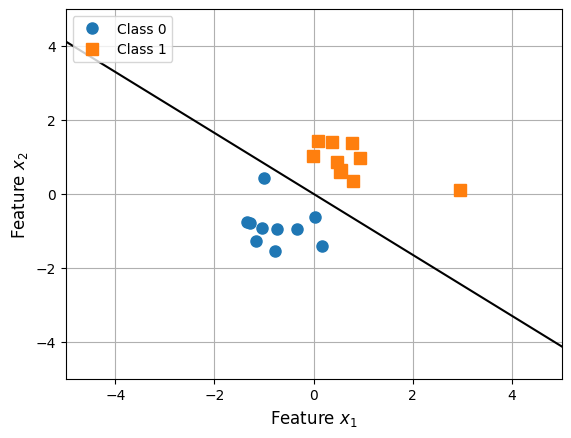

In [482]:
plot_feature2d(X_train, y_train, bias, weights, markersize=8)